# Big Pharma Stock Data Forecasting
## by Abdulhaq Adetunji Salako

## Introduction
Big Pharma is a large pharmaceutical distribution company in Germany. The data set has been stored as a csv file, it has 3 features and 1048575 entries. The features including Date, Product ID,and Stock Demand.

## Preliminary Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")


import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing


A quick look at the information about the dataset, using pandas shape, info,and describe method.


<ul>
  <li>Date: The date a product was purchased</li>
  <li>Product ID: The ID for the product</li>
  <li>Stock Demand: The quantity of product purchased (unit is in boxes)</li>
</ul>




In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('pharmaceutical-sales-demand.csv') 

In [3]:
df.head()

,Date,Product ID,Stock Demand
0,10/5/2020,I6DO4,-1
1,10/5/2020,O40SR,16
2,10/19/2020,Y03MS,306
3,10/8/2020,B0OR2,307
4,10/2/2020,EIM03,6


In [4]:
df.shape

(1048575, 3)

In [5]:
df.describe()

,Stock Demand
count,1.048575e+06
mean,7.970586e+01
std,6.100230e+02
min,-1.222600e+04
25%,3.000000e+00
50%,9.000000e+00
75%,3.100000e+01
max,1.490040e+05


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Date          1048575 non-null  object
 1   Product ID    1048575 non-null  object
 2   Stock Demand  1048575 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 24.0+ MB


# Data Cleaning

The **Time** column is stored as a string. To convert it to datetime, the function pd.to_datetime() is used.

In [7]:
# Converting Date from String to datetime64
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Date          1048575 non-null  datetime64[ns]
 1   Product ID    1048575 non-null  object        
 2   Stock Demand  1048575 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 24.0+ MB


In [9]:
# change all features naming conventions 
df = df.rename(columns={'Product ID': 'product_id','Date':'date' ,'Stock Demand': 'stock_demand'})

In [10]:
df.sample(5)

,date,product_id,stock_demand
437861,2021-01-19,1IXM0,16
177735,2020-11-27,LU10G,4
551373,2021-03-28,R10ES,9
999039,2021-06-23,4I3PA,4
1015598,2021-07-14,N0SI1,6


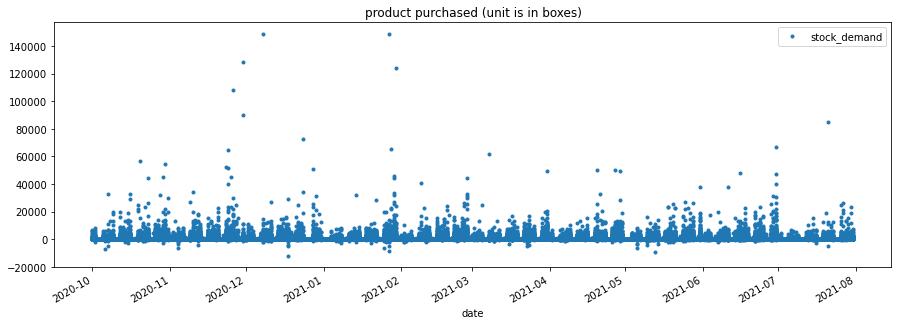

In [11]:
df.plot(x="date",y="stock_demand" ,style='.',
        figsize=(15, 5),
        title='product purchased (unit is in boxes)')
plt.show()

In [12]:
#Date Features
def date_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_week'] = df['date'].dt.dayofweek
    df['week_of_year'] = df['date'].dt.isocalendar().week
    
    # Drop date
    df.drop('date', axis=1, inplace=True)
    
    return df

In [13]:
df = date_features(df)

df.sample(5)

,product_id,stock_demand,year,month,day,day_of_year,day_of_week,week_of_year
472316,U0O1L,7,2021,2,22,53,0,8
585824,1DS0M,34,2021,3,26,85,4,12
144922,1G0LI,57,2020,11,4,309,2,45
591424,UCT01,147,2021,3,23,82,1,12
688892,1IRT0,11,2021,4,20,110,1,16


In [14]:
df_stock = df.copy()
pd.concat([df_stock.head(5),df_stock.tail(5)])

,product_id,stock_demand,year,month,day,day_of_year,day_of_week,week_of_year
0,I6DO4,-1,2020,10,5,279,0,41
1,O40SR,16,2020,10,5,279,0,41
2,Y03MS,306,2020,10,19,293,0,43
3,B0OR2,307,2020,10,8,282,3,41
4,EIM03,6,2020,10,2,276,4,40
1048570,E2V0E,262,2021,7,28,209,2,30
1048571,E1SC3,5,2021,7,30,211,4,30
1048572,A2SN0,5235,2021,7,22,203,3,29
1048573,G020L,3,2021,7,30,211,4,30
1048574,RT2A0,1,2021,7,30,211,4,30


In [15]:
df_stock['date'] =  pd.to_datetime(df_stock[["year","month","day"]])
df_stock['date'].agg(['min', 'max'])


min   2020-10-01
max   2021-07-31
Name: date, dtype: datetime64[ns]

In [16]:
df_stock['date'].agg(['min', 'max'])

min   2020-10-01
max   2021-07-31
Name: date, dtype: datetime64[ns]

In [17]:
df_stock.groupby('product_id').stock_demand.value_counts()

product_id  stock_demand
0010R       1               6
            2               3
            5               2
            3               1
            6               1
                           ..
ZVI02       51              1
            56              1
            3000            1
            3001            1
            3003            1
Name: stock_demand, Length: 311972, dtype: int64

In [18]:
df_stock.isna().sum()

product_id      0
stock_demand    0
year            0
month           0
day             0
day_of_year     0
day_of_week     0
week_of_year    0
date            0
dtype: int64

In [19]:
#Exploratory Visual

# default sns theme
sns.set_style('darkgrid')

colorChoice = sns.color_palette()[0]

In [20]:
df_stock.year.value_counts()

2021    715731
2020    332844
Name: year, dtype: int64

In [21]:
df_stock['stock_demand'].agg(['min', 'max','mean'])

min     -12226.000000
max     149004.000000
mean        79.705856
Name: stock_demand, dtype: float64

 ### Outlier Analysis and removal

Text(0.5, 0, 'Stock Demand')

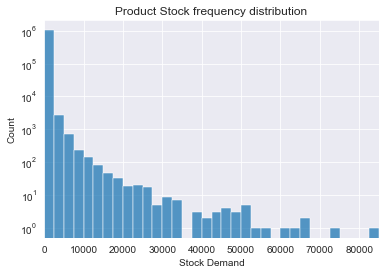

In [22]:
bin_edges = np.arange(0,df_stock['stock_demand'].max()+5000,2500)
sns.histplot(data=df_stock,x='stock_demand',bins=bin_edges).set(title='Product Stock frequency distribution');
plt.yscale('log')
plt.xlim(0,85000)
plt.xlabel('Stock Demand')

<AxesSubplot:title={'center':'product purchased (unit is in boxes)'}, xlabel='date'>

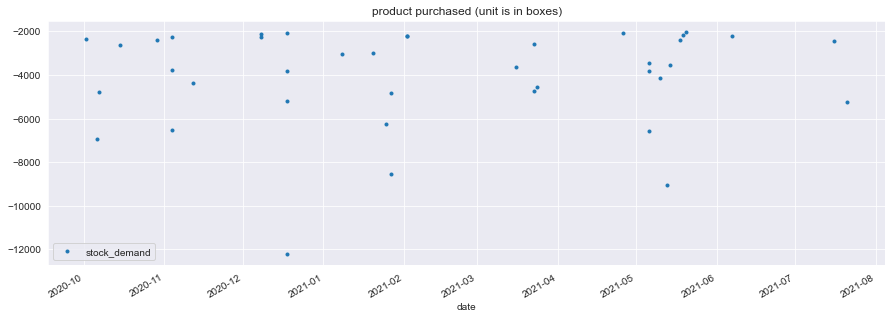

In [23]:
df_stock.query('stock_demand < -2000').plot(x="date",y="stock_demand" ,style='.',
        figsize=(15, 5),
        title='product purchased (unit is in boxes)')


<AxesSubplot:title={'center':'product purchased (unit is in boxes)'}, xlabel='date'>

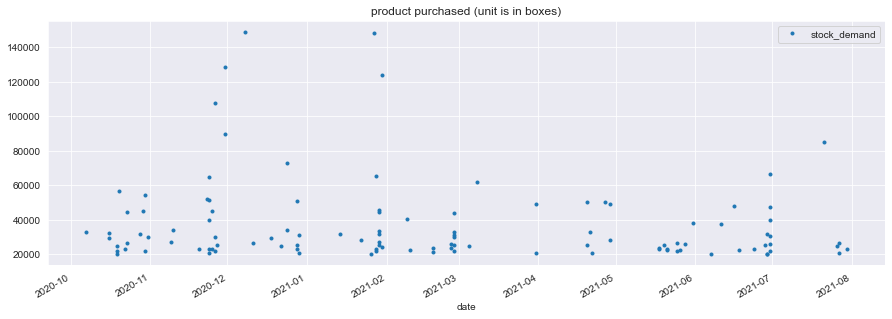

In [24]:
df_stock.query('stock_demand > 20000').plot(x="date",y="stock_demand" ,style='.',
        figsize=(15, 5),
        title='product purchased (unit is in boxes)')


In [25]:
df_stock = df[(df_stock['stock_demand'] >= -2000) & (df_stock['stock_demand'] <= 20000)].copy()
#df_stock.query(("stock_demand < 40000") and ("stock_demand < -2000")).copy()

In [26]:
df_stock.shape

(1048425, 8)

In [27]:
df_stock.sample(5)

,product_id,stock_demand,year,month,day,day_of_year,day_of_week,week_of_year
330818,A03NR,2,2020,12,18,353,4,51
708745,2I0SO,6,2021,4,11,101,6,14
76138,TS6O0,7,2020,10,27,301,1,44
716068,ZDS30,14,2021,4,5,95,0,14
827056,0ET3P,2,2021,5,18,138,1,20


Annual, weekly and daily seasonality

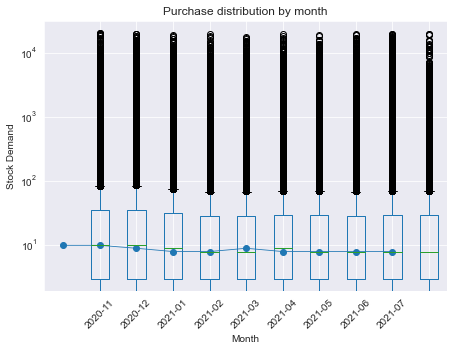

In [28]:
# Boxplot for annual seasonality
df_stock['y_m'] = pd.to_datetime(df_stock[["year","month","day"]])
df_stock['y_m']  = df_stock['y_m'].dt.strftime('%Y-%m')

fig, ax = plt.subplots(figsize=(7, 5))
df_stock.boxplot(column='stock_demand', by='y_m', ax=ax)
df_stock.groupby('y_m')['stock_demand'].median().plot(style='o-', linewidth=0.8, ax=ax)

ax.set_yscale('log')
# plt.yticks(ticks, labels);
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Stock Demand')
ax.set_xlabel('Month')
ax.set_title('Purchase distribution by month')
fig.suptitle('');

It is observed that there is annual seasonality with downward decrease starting october 2020 and highest (median) demand values in march 2021 

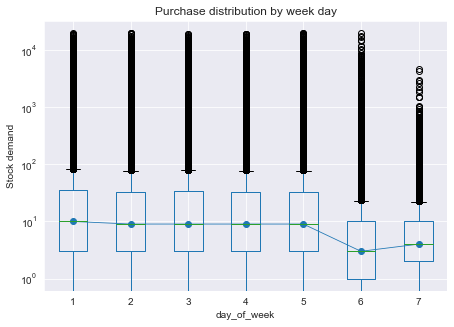

In [29]:
# Boxplot for weekly seasonality
fig, ax = plt.subplots(figsize=(7, 5))
df_stock['day_of_week'] = df_stock.day_of_week + 1
df_stock.boxplot(column='stock_demand', by='day_of_week', ax=ax)
df_stock.groupby('day_of_week')['stock_demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Stock demand')
ax.set_title('Purchase distribution by week day')
ax.set_yscale('log')
fig.suptitle('');

Weekly seasonality shows lower demand values during the weekend.

Daily, Monthly Average for data

In [30]:
df_stock['daily_avg']  = df_stock.groupby(['product_id','day_of_week'])['stock_demand'].transform('mean')
df_stock['monthly_avg'] = df_stock.groupby(['product_id','month'])['stock_demand'].transform('mean')

df_stock.sample(10)

,product_id,stock_demand,year,month,day,day_of_year,day_of_week,week_of_year,y_m,daily_avg,monthly_avg
596782,ST6R1,9,2021,3,8,67,1,10,2021-03,7.000000,6.875000
60672,R10HA,4,2020,10,29,303,4,44,2020-10,12.980769,6.000000
515387,RC0I1,21,2021,2,23,54,2,8,2021-02,24.923077,16.230769
2520,3BIO2,1,2020,10,9,283,5,41,2020-10,5.800000,4.864865
764874,V0TI4,3,2021,4,7,97,3,14,2021-04,25.612676,35.512195
761894,4SN0O,1,2021,4,29,119,4,17,2021-04,769.266667,1156.869565
943710,0VO1M,10,2021,6,8,159,2,23,2021-06,28.291667,10.724138
1011918,0IL1D,64,2021,7,25,206,7,29,2021-07,33.648649,84.333333
536164,01UAN,1,2021,2,3,34,3,5,2021-02,10.277778,4.294118
997321,BA20G,62,2021,6,18,169,5,24,2021-06,46.151899,60.533333


In [31]:
# Average sales for Day_of_week = d per Item,Store
daymonth_avg = df_stock.groupby(['product_id','day_of_week'])['stock_demand'].mean().reset_index()
# Average sales for Month = m per Item,Store
monthly_avg = df_stock.groupby(['product_id','month'])['stock_demand'].mean().reset_index()

print(daymonth_avg,monthly_avg)

      product_id  day_of_week  stock_demand
0          0010R            1      2.833333
1          0010R            2      4.000000
2          0010R            3      1.000000
3          0010R            4      1.500000
4          0010R            5      1.000000
...          ...          ...           ...
45249      ZVI02            3      9.606061
45250      ZVI02            4    210.000000
45251      ZVI02            5    141.565217
45252      ZVI02            6      2.000000
45253      ZVI02            7      2.000000

[45254 rows x 3 columns]       product_id  month  stock_demand
0          0010R      2      1.000000
1          0010R      3      2.666667
2          0010R      4      2.000000
3          0010R      5      1.000000
4          0010R      6      5.000000
...          ...    ...           ...
63946      ZVI02      6    174.777778
63947      ZVI02      7      6.400000
63948      ZVI02     10     17.750000
63949      ZVI02     11      5.812500
63950      ZVI02     12     

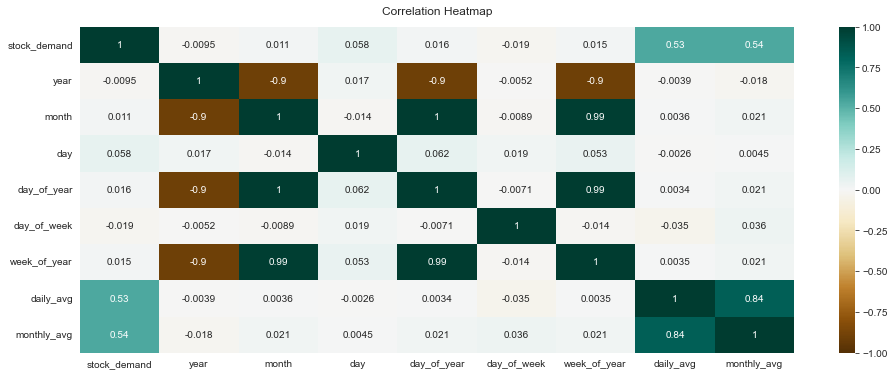

In [32]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_stock.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Reviewing: Train / Test Split

In [33]:
label_encoder = preprocessing.LabelEncoder()

df_stock['id'] = df_stock.loc[:, 'product_id']

df_stock['id']= label_encoder.fit_transform(df_stock['id'])



In [34]:
df_stock['date'] = pd.to_datetime(df_stock[["year","month","day"]])

# Filter data using dates
train_df = df_stock.loc[(df_stock['date'] < '2021-05-01')]
test_df = df_stock.loc[(df_stock['date'] >= '2021-05-01')]
print(f'training data size : {train_df.shape}')
print(f'validation data size : {test_df.shape}')

training data size : (781699, 13)
validation data size : (266726, 13)


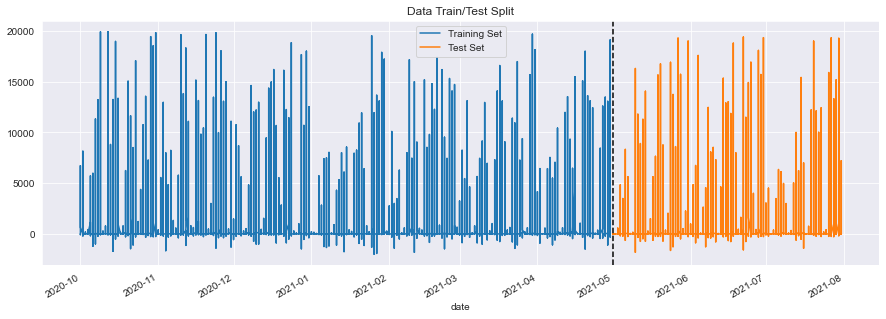

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))
train_df.plot(x='date' , y='stock_demand' ,ax=ax, label='Training Set', title='Data Train/Test Split')
test_df.plot( x='date' , y='stock_demand' ,ax=ax, label='Test Set')
ax.axvline('2021-05-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [36]:
train_df

,product_id,stock_demand,year,month,day,day_of_year,day_of_week,week_of_year,y_m,daily_avg,monthly_avg,id,date
0,I6DO4,-1,2020,10,5,279,1,41,2020-10,8.950000,0.333333,5121,2020-10-05
1,O40SR,16,2020,10,5,279,1,41,2020-10,62.394737,60.892308,6131,2020-10-05
2,Y03MS,306,2020,10,19,293,1,43,2020-10,190.200000,177.560000,7711,2020-10-19
3,B0OR2,307,2020,10,8,282,4,41,2020-10,154.100000,148.814815,3935,2020-10-08
4,EIM03,6,2020,10,2,276,5,40,2020-10,11.175676,10.681818,4638,2020-10-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
781802,R2GU0,2,2021,4,28,118,3,17,2021-04,3.090909,2.900000,6657,2021-04-28
781803,1N1TI,1,2021,4,26,116,1,17,2021-04,2.473684,2.333333,1547,2021-04-26
781804,0CL1O,1,2021,4,21,111,3,16,2021-04,92.351190,87.402062,420,2021-04-21
781805,OXD01,1,2021,4,26,116,1,17,2021-04,11.275862,7.900000,6299,2021-04-26


#### Time Series Cross Validation

In [37]:
tss = TimeSeriesSplit(n_splits=3, test_size=24*90*1, gap=24)
train_df = train_df.sort_values(by = 'date')
test_df = test_df.sort_values(by = 'date')
train_df

,product_id,stock_demand,year,month,day,day_of_year,day_of_week,week_of_year,y_m,daily_avg,monthly_avg,id,date
85664,R8I8O,16,2020,10,1,275,4,40,2020-10,10.485714,11.454545,6797,2020-10-01
33312,AA80R,2,2020,10,1,275,4,40,2020-10,4.750000,4.600000,3750,2020-10-01
107867,0P6IR,-6,2020,10,1,275,4,40,2020-10,81.293103,78.571429,860,2020-10-01
103344,I2L4V,7,2020,10,1,275,4,40,2020-10,9.416667,9.666667,5041,2020-10-01
107864,C731E,33,2020,10,1,275,4,40,2020-10,106.648649,367.607143,4121,2020-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
700318,06DLO,200,2021,4,30,120,5,17,2021-04,122.272727,61.312500,260,2021-04-30
748133,Q01AU,190,2021,4,30,120,5,17,2021-04,203.977273,116.181818,6470,2021-04-30
700322,G0I3V,385,2021,4,30,120,5,17,2021-04,654.823529,415.346154,4819,2021-04-30
748119,SHC12,15,2021,4,30,120,5,17,2021-04,3.800000,2.875000,7153,2021-04-30


In [38]:
for df in [train_df, test_df]:
    df.drop(['y_m',
                'week_of_year',
                'date',
                'product_id' ],
                 axis=1, 
                 inplace=True)

#### Train Using Cross Validation

In [39]:
FEATURES = ['day_of_year', 'day', 'month', 'day_of_week','year',
                'id','daily_avg','monthly_avg']

TARGET = 'stock_demand'


# Training Data
X_train = train_df[FEATURES]
y_train = train_df[TARGET]
# Test Data
X_test = test_df[FEATURES]
y_test = test_df[TARGET]



In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781699 entries, 85664 to 733919
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   day_of_year  781699 non-null  int64  
 1   day          781699 non-null  int64  
 2   month        781699 non-null  int64  
 3   day_of_week  781699 non-null  int64  
 4   year         781699 non-null  int64  
 5   id           781699 non-null  int32  
 6   daily_avg    781699 non-null  float64
 7   monthly_avg  781699 non-null  float64
dtypes: float64(2), int32(1), int64(5)
memory usage: 50.7 MB


In [41]:
import sys
!{sys.executable} -m pip install xgboost

In [42]:
preds = []
scores = []

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=500,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

y_pred = reg.predict(X_test)
preds.append(y_pred)
score = np.sqrt(mean_squared_error(y_test, y_pred))
scores.append(score)

[16:18:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:394.60250	validation_1-rmse:424.78539
[100]	validation_0-rmse:329.22906	validation_1-rmse:356.75783
[200]	validation_0-rmse:314.60049	validation_1-rmse:340.61425
[300]	validation_0-rmse:310.27316	validation_1-rmse:336.26443
[400]	validation_0-rmse:308.44089	validation_1-rmse:335.11101
[499]	validation_0-rmse:307.32503	validation_1-rmse:334.34618


In [43]:
print(f'Score in 1 folds {np.mean(scores):0.4f}')

Score in 1 folds 334.3462


In [44]:
# Retrain on all data
FEATURES = ['day_of_year', 'day', 'month', 'day_of_week','year',
                'id','daily_avg','monthly_avg']

TARGET = 'stock_demand'

X_all = df_stock[FEATURES]
y_all = df_stock[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[16:19:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:402.48844
[100]	validation_0-rmse:335.99880
[200]	validation_0-rmse:320.54882
[300]	validation_0-rmse:316.12699
[400]	validation_0-rmse:314.25647
[499]	validation_0-rmse:313.09759


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)